In [51]:
import geopandas as gpd
import pandas as pd

import networkx as nx
import osmnx as ox

import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['USE_PYGEOS'] = '0'
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, MultiLineString
from descartes import PolygonPatch

<h2>Adding Datasets</h2>

<h3>Vector Datasets</h3>

In [2]:
#Amsterdam City Boundary Polygon
url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=INDELING_GEBIED&THEMA=gebiedsindeling"
aNeighborhood = gpd.read_file(url)
aNeighborhood = aNeighborhood.to_crs('EPSG:32632')
amCity = aNeighborhood.dissolve()

In [3]:
#Amsterdam Bike Facilities
aGraph = ox.load_graphml('./data/Agraph.graphml')

<h3>Plots</h3>

<Axes: >

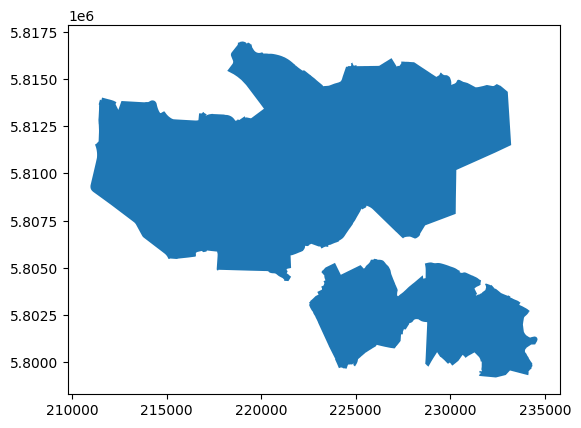

In [4]:
amCity.plot()

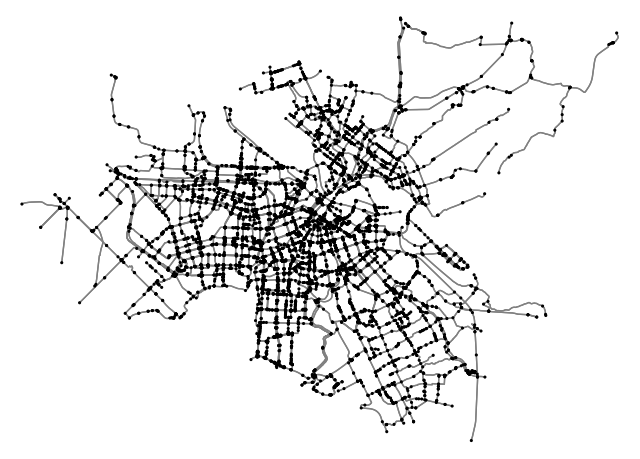

In [5]:
fig, ax = ox.plot_graph(aGraph, bgcolor='white', node_color='black', edge_color='grey', node_size=5)

<h2>Isochrone Polygons</h2>

In [6]:
graph_proj = ox.project_graph(aGraph, to_crs='EPSG:4326')
nodes = ox.graph_to_gdfs(graph_proj, nodes=True, edges=False)

In [9]:
nodes

,nodeID,x,y,lon,lat,geometry
osmid,,,,,,
0,0,4.899340,52.297860,220419.809892,5.802090e+06,POINT (4.89934 52.29786)
1,1,4.898348,52.298809,220358.215681,5.802199e+06,POINT (4.89835 52.29881)
717,717,4.899029,52.296014,220386.981358,5.801886e+06,POINT (4.89903 52.29601)
2,2,4.898045,52.299401,220341.273997,5.802266e+06,POINT (4.89804 52.29940)
3,3,4.898019,52.299206,220338.279676,5.802244e+06,POINT (4.89802 52.29921)
...,...,...,...,...,...,...
8491,8491,4.943101,52.402877,224057.701856,5.813595e+06,POINT (4.94310 52.40288)
8492,8492,4.941557,52.403495,223956.566638,5.813669e+06,POINT (4.94156 52.40349)
8498,8498,4.962184,52.373700,225173.747196,5.810279e+06,POINT (4.96218 52.37370)


In [22]:
#amsterdam coordinates are [52.366406834913555, 4.904990368266913]
test = nodes[nodes['y']>52.366]
test = test[test['y']<52.367]
test = test[test['x']> 4.90]
test = test[test['x']<4.901]
test

,nodeID,x,y,lon,lat,geometry
osmid,,,,,,
4957,4957,4.900509,52.366332,220931.304278,5.809696e+06,POINT (4.90051 52.36633)
4546,4546,4.900562,52.366221,220934.194813,5.809684e+06,POINT (4.90056 52.36622)
4547,4547,4.900216,52.366274,220910.985817,5.809691e+06,POINT (4.90022 52.36627)


In [23]:
node_manual = 4957
sGraph = ox.project_graph(graph_proj, to_crs='EPSG:32632')

In [24]:
travel_speed = 16
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute

for u, v, data in aGraph.edges.data():
    data['time'] = data['length'] / meters_per_minute

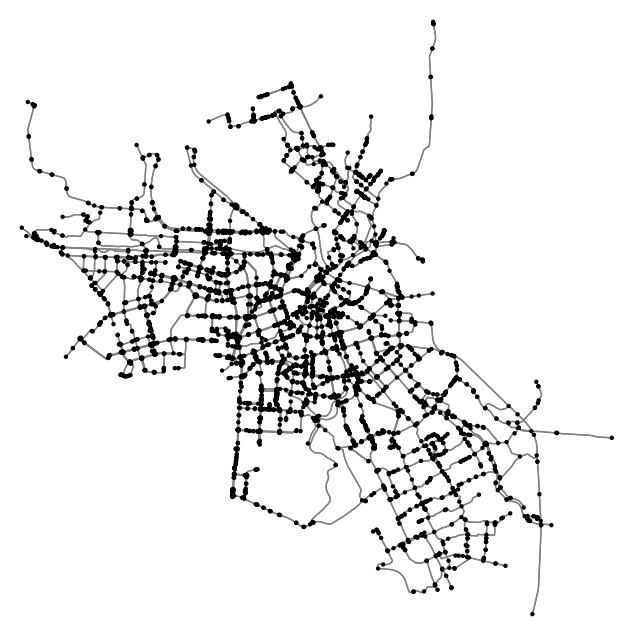

In [25]:
subgraph = nx.ego_graph(aGraph, node_manual, radius=360, distance="time")
fig, ax = ox.plot_graph(subgraph, bgcolor='white', node_color='black', edge_color='grey', node_size=10)

In [26]:
trip_times = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]  # in minutes
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_10120/2306092675.py:2: FutureWarning: The `return_hex` parameter has been deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)


In [27]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph1 = nx.ego_graph(aGraph, node_manual, radius=trip_time, distance="time")
    for node in subgraph1.nodes():
        node_colors[node] = color

nc = [node_colors[node] if node in node_colors else "none" for node in aGraph.nodes()]
ns = [10 if node in node_colors else 0 for node in aGraph.nodes()]

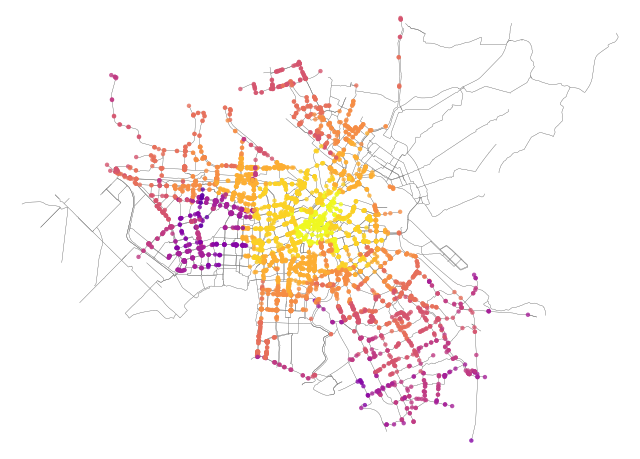

In [28]:
fig, ax = ox.plot_graph(aGraph, node_color=nc, node_size=ns, node_alpha=0.8,
    edge_linewidth=0.2, edge_color="grey", bgcolor='white')

In [31]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, node_manual, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [32]:
isochrone_polys = make_iso_polys(aGraph, edge_buff=25, node_buff=0, infill=True)

In [33]:
poly_gdf = gpd.GeoDataFrame(geometry=isochrone_polys)
poly_gdf = poly_gdf.set_crs('EPSG:32632')

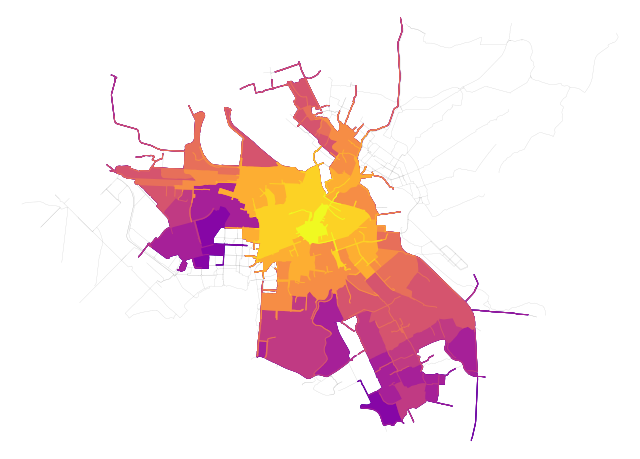

In [56]:
fig, ax = ox.plot_graph(aGraph, show=False, close=False, edge_linewidth=0.2, 
                        edge_color="grey", bgcolor='white', edge_alpha=0.2, node_size=0)
poly_gdf.plot(ax=ax, color=iso_colors)
plt.savefig('./maps/AmsterdamNetwork_Current_nobg.jpeg')
plt.show()

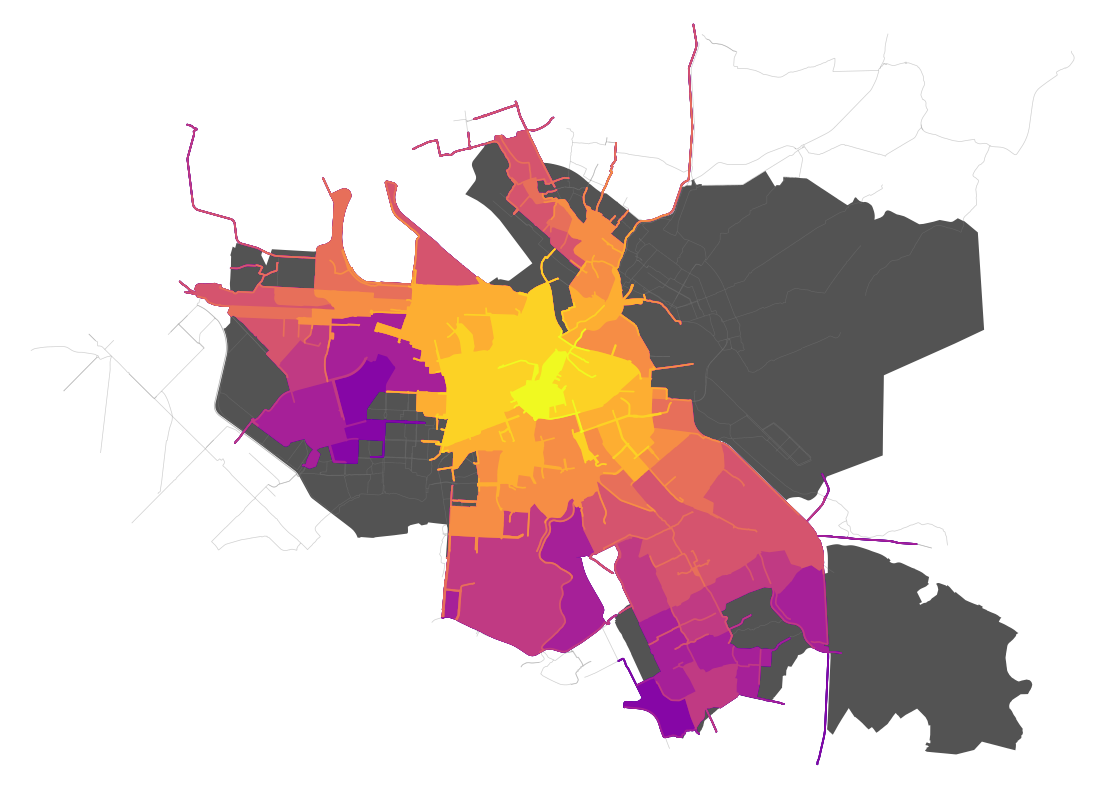

In [55]:
fig, ax = plt.subplots(figsize=(14,10))
#maybe some type of base map to show where the water is
amCity.plot(ax=ax, color='#535353')
ox.plot_graph(aGraph, ax=ax, show=False, close=False, edge_linewidth=0.5, 
                        edge_color="grey", bgcolor='white', edge_alpha=0.2, node_size=0)
poly_gdf.plot(ax=ax, color=iso_colors)
ax.set_axis_off()
plt.savefig('./maps/AmsterdamNetwork_Current.jpeg')
plt.show()

<h2>Accessibility Calculations</h2>

In [37]:
aArea = amCity.area/1000000

In [41]:
min10 = poly_gdf.iloc[-1]
min10 = gpd.GeoDataFrame(geometry=min10)
min10 = min10.clip(amCity)
area10 = min10.area/1000000
per10 = (area10/aArea[0])*100
print(f'{per10[0]:.1f}% of Amsterdam is accessibile by bike within 10 minutes from the city center.')

1.0% of Amsterdam is accessibile by bike within 10 minutes from the city center.


/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_10120/3871011363.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{per10[0]:.1f}% of Amsterdam is accessibile by bike within 10 minutes from the city center.')


In [45]:
min30 = poly_gdf.iloc[-3]
min30 = gpd.GeoDataFrame(geometry=min30)
min30 = min30.clip(amCity)
area30 = min30.area/1000000
per30 = (area30/aArea[0])*100
print(f'{per30[0]:.1f}% of Amsterdam is accessibile by bike within 30 minutes from the city center.')

13.9% of Amsterdam is accessibile by bike within 30 minutes from the city center.


/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_10120/4104827371.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{per30[0]:.1f}% of Amsterdam is accessibile by bike within 30 minutes from the city center.')


In [46]:
min60 = poly_gdf.iloc[-6]
min60 = gpd.GeoDataFrame(geometry=min60)
min60 = min60.clip(amCity)
area60 = min60.area/1000000
per60 = (area60/aArea[0])*100
print(f'{per60[0]:.1f}% of Amsterdam is accessibile by bike within 60 minutes from the city center.')

29.6% of Amsterdam is accessibile by bike within 60 minutes from the city center.


/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_10120/3899832841.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{per60[0]:.1f}% of Amsterdam is accessibile by bike within 60 minutes from the city center.')


In [47]:
min90 = poly_gdf.iloc[3]
min90 = gpd.GeoDataFrame(geometry=min90)
min90 = min90.clip(amCity)
area90 = min90.area/1000000
per90 = (area90/aArea[0])*100
print(f'{per90[0]:.1f}% of Amsterdam is accessibile by bike within 90 minutes from the city center.')

43.8% of Amsterdam is accessibile by bike within 90 minutes from the city center.


/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_10120/3009887295.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{per90[0]:.1f}% of Amsterdam is accessibile by bike within 90 minutes from the city center.')


In [50]:
min120 = poly_gdf.iloc[0]
min120 = gpd.GeoDataFrame(geometry=min120)
min120 = min120.clip(amCity)
area120 = min120.area/1000000
per120 = (area120/aArea[0])*100
print(f'{per120[0]:.1f}% of Amsterdam is accessibile by bike within 120 minutes from the city center.')

43.8% of Amsterdam is accessibile by bike within 120 minutes from the city center.


/var/folders/6h/mjkfjbdx5j33s6js5qfxw5f40000gn/T/ipykernel_10120/1765940973.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{per120[0]:.1f}% of Amsterdam is accessibile by bike within 120 minutes from the city center.')
